# Transformer models

**Table of Contents**

* Prepare data
* SASRec model
    * Model description
    * Recommendations
    * RecTools implementation
        * Additional details
    * Model application
        * SASRec with item ids embeddings in ItemNetBlock
        * SASRec with item ids and category features embeddings in ItemNetBlock
        * SASRec with category item features embeddings in ItemNetBlock
        * Additional details
    * Under the hood: Transformer layers
* BERT4Rec model
    * Model description
    * Recommendations
* Under the hood: Dataset processing




In [2]:
import sys
sys.path.append("/data/home/maspirina1/tasks/repo/RecTools/")

In [3]:
import numpy as np
import os
import pandas as pd
import torch
import typing as tp

from lightning_fabric import seed_everything
from pathlib import Path

from rectools import Columns
from rectools.dataset import Dataset
from rectools.models.sasrec import CatFeaturesItemNet, IdEmbeddingsItemNet, SASRecModel
from rectools.models.bert4rec import BERT4RecModel

# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Prepare data

We are using KION dataset for this tutorial. The data was gathered from the users of MTS KION video streaming platform.

In [5]:
%%time
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_en.zip -O data_en.zip
!unzip -o data_en.zip
!rm data_en.zip

Archive:  data_en.zip
   creating: data_en/
  inflating: data_en/items_en.csv    
  inflating: __MACOSX/data_en/._items_en.csv  
  inflating: data_en/interactions.csv  
  inflating: __MACOSX/data_en/._interactions.csv  
  inflating: data_en/users_en.csv    
  inflating: __MACOSX/data_en/._users_en.csv  
CPU times: user 272 ms, sys: 105 ms, total: 377 ms
Wall time: 12.6 s


In [6]:
# Download dataset
DATA_PATH = Path("data_en")
items = pd.read_csv(DATA_PATH / 'items_en.csv', index_col=0)
interactions = (
    pd.read_csv(DATA_PATH / 'interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={"last_watch_dt": Columns.Datetime})
)
print(interactions.shape)
interactions.head(2)

(5476251, 5)


,user_id,item_id,datetime,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0


In [7]:
# Process interactions
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)
interactions = interactions[["user_id", "item_id", "datetime", "weight"]]
print(interactions.shape)
interactions.head(2)

(5476251, 4)


,user_id,item_id,datetime,weight
0,176549,9506,2021-05-11,3
1,699317,1659,2021-05-29,3


In [8]:
print(items.shape)
items.head(2)

(15963, 16)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,description,keywords,actors_translated,actors_transliterated,directors_translated,transliterated
0,10711,film,Talk to her,Hable con ella,2002.0,"drama, foreign, detective, melodrama",Spain,NaN,16.0,NaN,"Marco, a journalist, interviews the famous Tor...","Talk, her, 2002, Spain, friends, love, strong,...","Adolfo Fernández, Ana Fernández, Dario Grandin...","Adol'fo Fernandes, Ana Fernandes, Dario Grandi...",Pedro Almodovar,Pedro Al'modovar
1,2508,film,Naked Peppers,Search Party,2014.0,"foreign, adventure, comedy",USA,NaN,16.0,NaN,The main character has learned not to invite h...,"Naked, Peppers, 2014, USA, friends, weddings, ...","Adam Palley, Brian Huskey, JB Smoove, Jason Ma...","Adam Palli, Brajan Haski, Dzh.B. Smuv, Dzhejso...",Scott Armstrong,Skot Armstrong


In [9]:
# Process item features
items = items.loc[items[Columns.Item].isin(interactions[Columns.Item])].copy()
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"
item_features = pd.concat((genre_feature, content_feature))

In [10]:
item_features.head()

,id,value,feature
0,10711,drama,genre
0,10711,foreign,genre
0,10711,detective,genre
0,10711,melodrama,genre
1,2508,foreign,genre


In [11]:
# Create datasets
dataset_no_features = Dataset.construct(
    interactions_df=interactions,
)

dataset_item_features = Dataset.construct(
    interactions_df=interactions,
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

# SASRec
## SASRec model description

SASRec is a transformer-based sequential model with unidirectional attention mechanism and "Shifted Sequence" training objective. 

As an input SASRec takes user sequences, containig previous user interaction history. Description of how they are created from user-item interactions can be found in "Under the hood: Dataset processing" part. Item embeddings from these sequences are fed to multi-head self-attention to acquire user sequence latent represenation. After one or several stacked attention blocks, resulting embeddings are used to predict next item.

In contrust to BERT4Rec, another transformer-based recommender model, SASRec is a causal model. It applies causal mask to enforce model focus solely on past interactions.


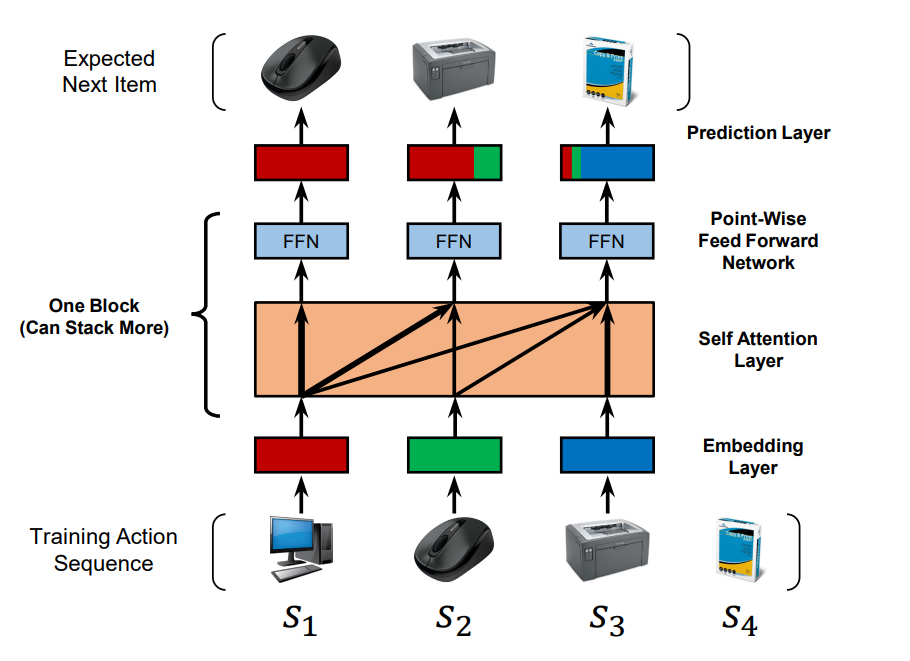

## Recommendations

After that implicit ranker is applied to make recommendations. Implicit ranker bases on implicit library matrix factorization topk method that:
* Receives as input:
    * Item embeddings
    * User sequence latent embeddings. Similarly to train stage, user sequence item embeddings are passed through transformer blocks and layer normalization to receive latent representation.
* Finds relevanace of each item by multiplication of user and item embeddings
* Returns items within topk with greates relevance

For u2i recommendations DOT distance is applied to find item relevance, for i2i - COSINE

## RecTools implementation
Current implementation uses architecture offered by the authors of original article. IIn addition to original model cross-entropy loss and gBCE loss with uniform negative sampling are supported.

**TODO: Add category item features emebeddings**

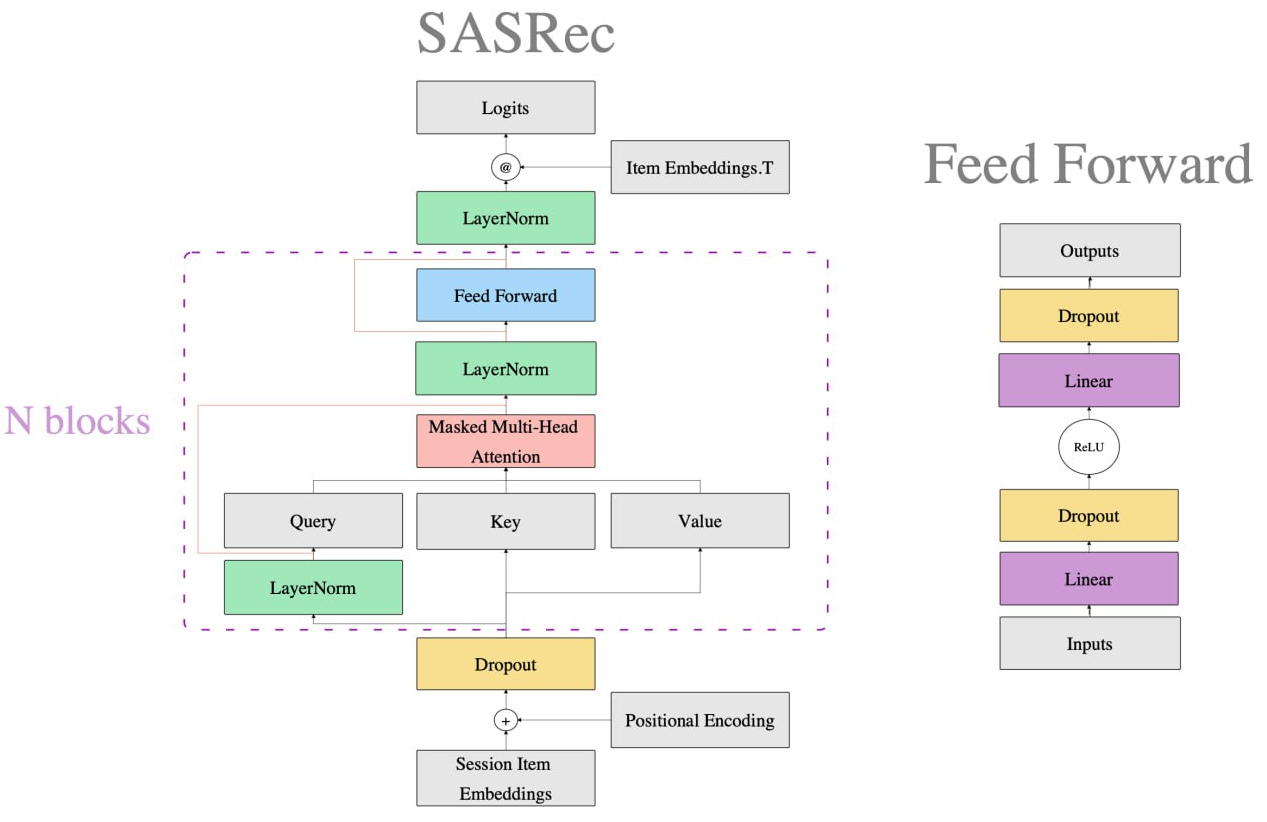

### Additional details
1. Xavier normal initialization for model parameters
2. Adam optimizer with betas=(0.9, 0.98) is used
3. Masked multi-head attention uses attention and timeline mask
4. Cross-entropy loss without reduction is applied, ignoring 0 index not to take into account pad element. 

## Model Application

In [12]:
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

Seed set to 60


60

In [13]:
# Prepare test user
test_user = [176549] 
print(interactions[interactions["user_id"] == test_user[0]].shape)
interactions[interactions["user_id"] == test_user[0]].head(2)

(82, 4)


,user_id,item_id,datetime,weight
0,176549,9506,2021-05-11,3
3815,176549,15469,2021-05-25,3


* Specify latent embeddings size with `n_factors`
* Specify number of self-attention blocks with `n_blocks` 
* Specify number of attention heads with `n_heads`
* Specify `dropout_rate`
* Specify whether positional encoding should be used with `use_pos_emb`
* Specify whether causal mask should be used with `use_causal_attn`, for SASRec it is True by default
* Specify whether padding mask should be used with `use_key_padding_mask`, for SASRec it is False by default
* Specify maximum length of user-item interaction history with `session_max_len`
* Specify `loss` from "softmax", "BCE", "gBCE"
* Specify minimum number of user interactions in train dataset with `train_min_user_interaction`
* Specify `lr` for learning rate 
* Specify `batch_size`
* Specify `dataloader_num_workers`
* Specify `cpu_n_threads`
* Specify `verbose`
* Specify `epochs` for number of model training epochs
* Specify `item_net_block_types` for Item Net blocks from (IdEmbeddingsItemNet, CatFeaturesItemNet), (IdEmbeddingsItemNet,),            (, CatFeaturesItemNet)
* Specify lightning trainer with `trainer`

For custom classes: inherit from base class and pass custom class as model parameter
* Specify `pos_encoding_type` for custom positional encoding logic. Inherit from `PositionalEncodingBase`
* Specify `transformer_layers_type` for custom transformer layers logic. Inherit from `TransformerLayersBase`
* Specify `data_preparator_type` for custom data processing logic. Inherit from `SessionEncoderDataPreparatorBase`
* Specify `lightning_module_type` for custom training logic. Inherit from `SessionEncoderLightningModuleBase`

In [14]:
n_factors=128
session_max_len=32

In [15]:
def recommend(model: SASRecModel, test_user: tp.List[int], dataset: Dataset, k: int, filter_view: bool, on_unsupported_targets: str) -> pd.DataFrame:
    recos = model.recommend(
        users=test_user, 
        dataset=dataset,
        k=k,
        filter_viewed=filter_view,
        on_unsupported_targets=on_unsupported_targets,
    )
    return recos.merge(items[["item_id", "title_orig"]], on="item_id").sort_values(["user_id", "rank"])

### SASRec with item ids embeddings in ItemNetBlock

In [17]:
model = SASRecModel(
    n_factors=n_factors, 
    n_blocks=2,
    n_heads=1,
    dropout_rate=0.2,
    use_pos_emb=True,
    session_max_len=session_max_len,
    lr=1e-3,
    batch_size=128,
    epochs=5,
    loss="softmax",
    verbose=1,
    deterministic=True,
    item_net_block_types=(IdEmbeddingsItemNet, )  # Use only item ids in ItemNetBlock
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
%%time
model.fit(dataset_no_features)

Missing logger folder: /data/home/maspirina1/tasks/repo/RecTools/examples/tutorials/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type                           | Params
---------------------------------------------------------------
0 | torch_model | TransformerBasedSessionEncoder | 2.1 M 
---------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.207     Total estimated model params size (MB)
/data/home/maspirina1/tasks/repo/RecTools/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=143` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 11min 24s, sys: 27.4 s, total: 11min 51s
Wall time: 11min 41s


In [19]:
%%time
recommend(
    model=model,
    test_user=test_user,
    dataset=dataset_no_features,
    k=3,
    filter_view=True,
    on_unsupported_targets="warn",
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


/data/home/maspirina1/tasks/repo/RecTools/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=143` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

CPU times: user 2.54 s, sys: 1.42 s, total: 3.95 s
Wall time: 733 ms


,user_id,item_id,score,rank,title_orig
0,176549,11749,2.834625,1,Incredibles 2
1,176549,7310,2.768771,2,Despicable Me 2
2,176549,15266,2.686491,3,Monsters University


### SASRec with item ids and category features embeddings in ItemNetBlock

In [17]:
model = SASRecModel(
    n_factors=n_factors, 
    n_blocks=2,
    n_heads=1,
    dropout_rate=0.2,
    use_pos_emb=True,
    session_max_len=session_max_len,
    lr=1e-3,
    batch_size=128,
    epochs=5,
    loss="softmax",
    verbose=1,
    deterministic=True,
    item_net_block_types=(IdEmbeddingsItemNet, CatFeaturesItemNet)  # Use item ids and cat features in ItemNetBlock
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
%%time
model.fit(dataset_item_features)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type                           | Params
---------------------------------------------------------------
0 | torch_model | TransformerBasedSessionEncoder | 2.1 M 
---------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.288     Total estimated model params size (MB)
/data/home/amsemenov2/git/RecTools_origin/RecTools/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=143` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/data/home/amsemenov2/git/RecTools_origin/RecTools/rectools/dataset/features.py:424: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")
`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 13min 57s, sys: 22.1 s, total: 14min 19s
Wall time: 14min 12s


In [19]:
%%time
recommend(
    model=model,
    test_user=test_user,
    dataset=dataset_item_features,
    k=3,
    filter_view=True,
    on_unsupported_targets="warn",
)

/data/home/amsemenov2/git/RecTools_origin/RecTools/rectools/dataset/features.py:424: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")
100%|██████████| 1/1 [00:00<00:00, 217.36it/s]

CPU times: user 528 ms, sys: 561 ms, total: 1.09 s
Wall time: 209 ms


,user_id,item_id,score,rank,title_orig
0,176549,12965,3.708024,1,Cars 3
1,176549,11749,3.344521,2,Incredibles 2
2,176549,6774,3.321412,3,Cars 2


### SASRec with category item features embeddings in ItemNetBlock

In [20]:
model = SASRecModel(
    n_factors=n_factors, 
    n_blocks=2,
    n_heads=1,
    dropout_rate=0.2,
    use_pos_emb=True,
    session_max_len=session_max_len,
    lr=1e-3,
    batch_size=128,
    epochs=5,
    loss="softmax",
    verbose=1,
    deterministic=True,
    item_net_block_types=(CatFeaturesItemNet, )  # Use only cat item features in ItemNetBlock
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
%%time
model.fit(dataset_item_features)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type                           | Params
---------------------------------------------------------------
0 | torch_model | TransformerBasedSessionEncoder | 223 K 
---------------------------------------------------------------
223 K     Trainable params
0         Non-trainable params
223 K     Total params
0.895     Total estimated model params size (MB)
/data/home/amsemenov2/git/RecTools_origin/RecTools/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=143` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/data/home/amsemenov2/git/RecTools_origin/RecTools/rectools/dataset/features.py:424: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")
`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 13min 13s, sys: 19.5 s, total: 13min 33s
Wall time: 13min 25s


In [27]:
%%time
recommend(
    model=model,
    test_user=test_user,
    dataset=dataset_item_features,
    k=3,
    filter_view=True,
    on_unsupported_targets="warn",
)

/data/home/amsemenov2/git/RecTools_origin/RecTools/rectools/dataset/features.py:424: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")
100%|██████████| 1/1 [00:00<00:00, 222.04it/s]

CPU times: user 531 ms, sys: 512 ms, total: 1.04 s
Wall time: 128 ms


,user_id,item_id,score,rank,title_orig
0,176549,85,4.613278,1,Turbo
1,176549,12873,4.373979,2,Spies in Disguise
2,176549,6214,4.065771,3,Early Man


### Additional details
It may happen that SASRec filters out users with less than 2 interactions during train stage, as target is a shifted interaction sequence. However, it is still possible to make recommendations for user with one interaction in history if this interaction item was present at training.

As an example consider user 324373, for whom there is only one interaction in the dataset.

In [28]:
# Prepare test user with 1 interaction
test_user_recs = [324373] 
print(interactions[interactions["user_id"] == test_user_recs[0]].shape)
interactions[interactions["user_id"] == test_user_recs[0]]

(1, 4)


,user_id,item_id,datetime,weight
2493287,324373,10440,2021-06-24,3


In [29]:
%%time

recommend(
    model=model,
    test_user=test_user_recs,
    dataset=dataset_item_features,
    k=3,
    filter_view=True,
    on_unsupported_targets="warn",
)

/data/home/amsemenov2/git/RecTools_origin/RecTools/rectools/dataset/features.py:424: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")
100%|██████████| 1/1 [00:00<00:00, 224.93it/s]

CPU times: user 539 ms, sys: 481 ms, total: 1.02 s
Wall time: 126 ms


,user_id,item_id,score,rank,title_orig
0,324373,5747,3.753359,1,Station 19
1,324373,15282,3.699645,2,NaN
2,324373,10466,3.596605,3,Adjutant of His Excellency


Another case is when user had interactions, but all of the items were not present at the train stage. This may happen due to several reasons:
* Other users with this item were excluded due to lack of interactions
* User sequence exceeded `session_max_len` and was shortened 

If user does not have interactions containg items, which model knows, this user will not get recommendations.

In [30]:
# Prepare test user with items unknown by the model
test_user_no_recs = [14630] 
print(interactions[interactions["user_id"] == test_user_no_recs[0]].shape)
interactions[interactions["user_id"] == test_user_no_recs[0]].head(2)

(1, 4)


,user_id,item_id,datetime,weight
2393877,14630,8871,2021-03-28,3


Flag `on_unsupported_target` allows to monitor the number of users without any known items.

Flag options:
* "ignore" - skip such users, show warning with the number of cold users.
* "warn" - skip such users, show warning with the number of cold users and that cold users are not supported.
* "raise" - stop recommendation procedure.

In [31]:
%%time

recommend(
    model=model,
    test_user=test_user_no_recs,
    dataset=dataset_no_features,
    k=3,
    filter_view=True,
    on_unsupported_targets="warn",
)

CPU times: user 72.7 ms, sys: 2.96 ms, total: 75.7 ms
Wall time: 74.6 ms


/data/home/amsemenov2/git/RecTools_origin/RecTools/rectools/models/sasrec.py:635: UserWarning: 1 target users were considered cold because of missing known items
  warnings.warn(explanation)
/data/home/amsemenov2/git/RecTools_origin/RecTools/rectools/models/base.py:406: UserWarning: 
                Model `<class 'rectools.models.sasrec.SASRecModel'>` doesn't support recommendations for cold users,
                but some of given users are cold: they are not in the `dataset.user_id_map`
            
  warnings.warn(explanation)


,user_id,score,rank,item_id,title_orig


# Links
1. SASRec original paper: [Self-Attentive Sequential Recommendation](https://arxiv.org/abs/1808.09781)
2. [Turning Dross Into Gold Loss: is BERT4Rec really better than SASRec?](https://arxiv.org/abs/2309.07602)
3. [gSASRec: Reducing Overconfidence in Sequential Recommendation Trained with Negative Sampling](https://arxiv.org/pdf/2308.07192)

## Under the hood: Transformer layers

* Multi-head attention layer receives queries after layer normalisarion, keys and values without it. Masked attention is required to forbid model consider future interactions: cannot access element t+2 when predicting element t+1. Following notation from original article: 
$$ \text{Attention}(Q, K, V) = \text{softmax} (\frac {QK^T}{\sqrt{d}})V $$
$$S = SA(\hat{E}) = \text{Attention} (\hat{E}W^Q, \hat{E}W^K, \hat{E}W^V)$$

where $\hat{E}$ - input embedding
* Point-wise feed-forward network has the following structure: $F_i = \text{FFN}(S_i) = \text{ReLU}(S_i \cdot W^{(1)} + b^{(1)}) \cdot W^{(2)} + b^{(2)}$,

where $S_i, S_j$ - items of user sequence

$W_1, W_2$ - weights

$b_1, b_2$ - biases
* To avoid overfitting and stabelize training process, 2 residual connections are applied adding data after layer normalization.


# BERT4Rec

BERT4Rec is a transformer-based sequential model with bi-directional attention mechanism and "Item Masking" training objective.

As an input BERT4Rec receives user sequences, containing previous user interaction history. Description of how they are created from user-item interactions can be found in "Under the hood: Dataset processing" part. Item embeddings from these sequences are fed to multi-head self-attention to acquire user sequence latent represenation. After one or several stacked attention blocks, resulting embeddings are used to predict masked items.

Comparing BERT4Rec and SASRec main differences are:
* SASRec uses shifted sequence target, BERT4Rec - item masking target
* Models have different transformer block structures with varying activation functions. ReLU for SASRec and GELU for BERT4Rec
* SASRec uses uni-directional attention, BERT4Rec - bi-directional. Difference is illustrated in the following pictures

### BERT4Rec bi-directional attention

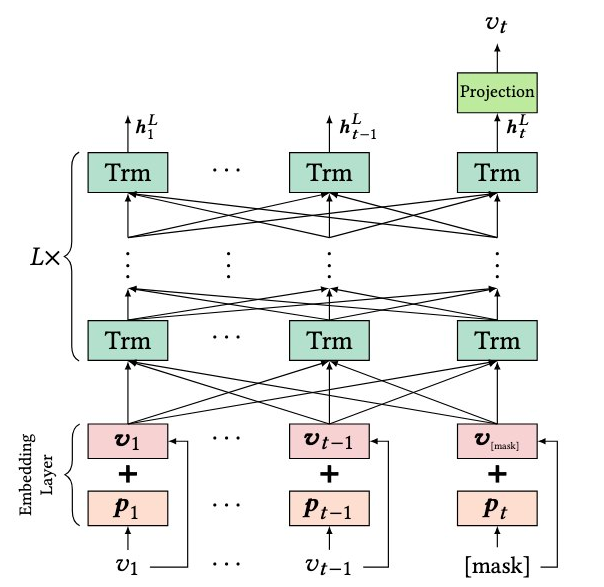

### SASRec uni-directional attention

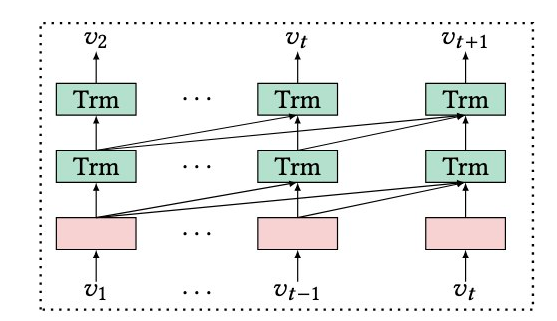

## Recommendations
After that implicit ranker is applied to make recommendations. Implicit ranker bases on implicit library matrix factorization topk method that:
* Receives as input:
    * Item embeddings
    * User sequence latent embeddings. Similarly to train stage, user sequence item embeddings are passed through transformer blocks and layer normalization to receive latent representation.
* Finds relevanace of each item by multiplication of user and item embeddings
* Returns items within topk with greates relevance

For u2i recommendations DOT distance is applied to find item relevance, for i2i - COSINE

## RecTools implementation

## Model Application
Parameter specific for BERT4Rec:
* Specify probability of a sequence item to be masked `mask_prob` 

Common transfromer model parameters:
* Specify latent embeddings size with `n_factors`
* Specify number of self-attention blocks with `n_blocks` 
* Specify number of attention heads with `n_heads`
* Specify `dropout_rate`
* Specify whether positional encoding should be used with `use_pos_emb`
* Specify whether causal mask should be used with `use_causal_attn`, for SASRec it is True by default
* Specify whether padding mask should be used with `use_key_padding_mask`, for SASRec it is False by default
* Specify maximum length of user-item interaction history with `session_max_len`
* Specify `loss` from "softmax", "BCE", "gBCE"
* Specify minimum number of user interactions in train dataset with `train_min_user_interaction`
* Specify `lr` for learning rate 
* Specify `batch_size`
* Specify `dataloader_num_workers`
* Specify `cpu_n_threads`
* Specify `verbose`
* Specify `epochs` for number of model training epochs
* Specify `item_net_block_types` for Item Net blocks from (IdEmbeddingsItemNet, CatFeaturesItemNet), (IdEmbeddingsItemNet,),            (, CatFeaturesItemNet)
* Specify lightning trainer with `trainer`

For custom classes: inherit from base class and pass custom class as model parameter
* Specify `pos_encoding_type` for custom positional encoding logic. Inherit from `PositionalEncodingBase`
* Specify `transformer_layers_type` for custom transformer layers logic. Inherit from `TransformerLayersBase`
* Specify `data_preparator_type` for custom data processing logic. Inherit from `SessionEncoderDataPreparatorBase`
* Specify `lightning_module_type` for custom training logic. Inherit from `SessionEncoderLightningModuleBase`

In [ ]:
model = BERT4RecModel(
    n_blocks=3,
    n_heads=4,
    dropout_rate=0.2,
    session_max_len=32,
    lr=1e-3,
    epochs=5,
    verbose=1,
    mask_prob=0.5,
    deterministic=True,
    item_net_block_types=(IdEmbeddingsItemNet, ),
)

In [ ]:
%%time
model.fit(dataset_no_features)

In [ ]:
%%time
recommend(
    model=model,
    test_user=test_user,
    dataset=dataset_no_features,
    k=3,
    filter_view=True,
    on_unsupported_targets="warn",
)

## Links
1. 
2. 
3. 

## Under the hood: Dataset processing

Preprocessing steps will be shown using toy dataset:

<table>
    <tr>
        <th> user_id </th>
        <th> item_id </th>
        <th> weight </th> 
        <th> datetime </th>
    </tr>
    <tr>
        <td>u1</td>
        <td>i1</td>
        <td>0.1</td>
        <td>2021-09-09</td>
    </tr>
        <tr>
        <td>u2</td>
        <td>i1</td>
        <td>0.3</td>
        <td>2021-09-09</td>
    </tr>
        <tr>
        <td>u2</td>
        <td>i3</td>
        <td>0.2</td>
        <td>2021-09-05</td>
    </tr>
        <tr>
        <td>u1</td>
        <td>i2</td>
        <td>0.3</td>
        <td>2021-09-07</td>
    </tr>
        <tr>
        <td>u3</td>
        <td>i2</td>
        <td>0.4</td>
        <td>2021-09-05</td>
    </tr>
        <tr>
        <td>u1</td>
        <td>i3</td>
        <td>0.5</td>
        <td>2021-09-08</td>
    </tr>
</table>

<b>SASRec:</b>
1. Filter out users with less than `train_min_user_interactions` interactions in train dataset. The model uses shifted user interactions to make next item prediction, thus at least 2 items should be in the history (`train_min_user_interactions` > 1). 

2. Leave `session_maxlen` most recent interactions for each user.

After first 2 steps, some users and/or items may be filtered out from train dataset. However, as it will be shown further, it is still possible to make recommendations for a previously unmet user, if interaction is known.

3. Create user sessions: for each user specify items with which there was an interaction in the order from earliest to most recent. Sessions for example dataset are the following:
$$S^1 = (i2, i3, i1)$$
$$S^2 = (i3, i1)$$

4. Before train stage each session is divided into train and target. As the task is to predict next item, shifted sequence is considered as target.
$$S^1_{train} = (i2, i3), S^1_{target} = (i3, i1)$$
$$S^2_{train} = (i3), S^2_{target} = (i1)$$
5. Both train and target sequences are adjusted to have user-defined `session_maxlen`:
    * If session is longer than `session_maxlen`, cut earliest items
    * If session is shorter than `session_maxlen`, pad earliest items with PAD element
$$S^1_{train} = (PAD, PAD, PAD, i2, i3), S^1_{target} = (PAD, PAD, PAD, i3, i1)$$
$$S^2_{train} = (PAD, PAD, PAD, PAD, i3), S^2_{target} = (PAD, PAD, PAD, PAD, i1)$$

<b>BERT4Rec:</b>
1. Filter out users with less than `train_min_user_interactions` interactions in train dataset.
2. Leave `session_maxlen` most recent interactions for each user.

After first 2 steps, some users and/or items may be filtered out from train dataset. However, as it will be shown further, it is still possible to make recommendations for a previously unmet user, if interaction is known.

3. Create user sessions: for each user specify items with which there was an interaction in the order from earliest to most recent. Sessions for example dataset are the following:
$$S^1 = (i2, i3, i1)$$
$$S^2 = (i3, i1)$$

4. Before train stage each session is divided into train and target. As the task is to predict masked item
$$S^1_{train} = (i2, i3), S^1_{target} = (i3, i1)$$
$$S^2_{train} = (i3), S^2_{target} = (i1)$$
5. Both train and target sequences are adjusted to have user-defined `session_maxlen`:
    * If session is longer than `session_maxlen`, cut earliest items
    * If session is shorter than `session_maxlen`, pad earliest items with PAD element
$$S^1_{train} = (PAD, PAD, PAD, i2, i3), S^1_{target} = (PAD, PAD, PAD, i3, i1)$$
$$S^2_{train} = (PAD, PAD, PAD, PAD, i3), S^2_{target} = (PAD, PAD, PAD, PAD, i1)$$